In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             roc_auc_score, ConfusionMatrixDisplay, f1_score,
                             accuracy_score)

In [2]:
images = [] # this will hold image data
classes = [] # this will hold corresponding class (1-32)

directory_path = "data/Leaves"

LEAVE_CLASSES = [(1001, 1059), (1060, 1122), (1552, 1616), (1123, 1194), (1195, 1267),
                 (1268, 1323), (1324, 1385), (1386, 1437), (1497, 1551), (1438, 1496),
                 (2001, 2050), (2051, 2113), (2114, 2165), (2166, 2230), (2231, 2290),
                 (2291, 2346), (2347, 2423), (2424, 2485), (2486, 2546), (2547, 2612),
                 (2616, 2675), (3001, 3055), (3056, 3110), (3111, 3175), (3176, 3229),
                 (3230, 3281), (3282, 3334), (3335, 3389), (3390, 3446), (3447, 3510),
                 (3511, 3563), (3566, 3621)]

def find_index(number):
    for idx, (start, end) in enumerate(LEAVE_CLASSES):
        if start <= number <= end:
            return idx

        
target_height = target_width = 64
        
for _, _, files in os.walk(directory_path): # we get root, dirs, files but we only want files
#     print(files)
    for file in files:
        image = tf.io.read_file(r"data/Leaves/"+file)
        image = tf.image.decode_jpeg(image, channels=3)

        target_height = target_width = 64
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, [target_height, target_width])
        
        image_index = find_index(int(file[:-4]))
              
        images.append(image / 255.0) # to rescale
        classes.append(str(image_index))

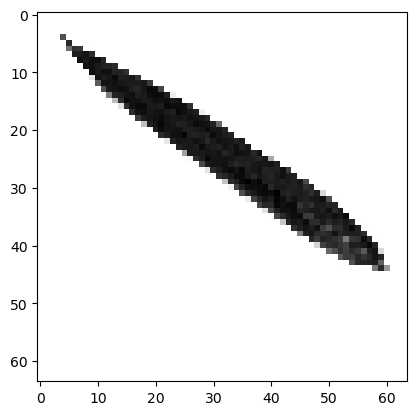

In [3]:
# this is just a demo of how we process the images

image = tf.io.read_file("data/Leaves/1001.jpg")
image = tf.image.decode_jpeg(image, channels=3)

target_height = target_width = 64
image = tf.image.rgb_to_grayscale(image)
image = tf.image.resize(image, [target_height, target_width])

plt.imshow(image.numpy(), cmap="gray")

I'm not sure whether one-hot-encoding is necessary here for the leave classes but I will transform my data anyways just to be safe.

In [4]:
num_classes = len(np.unique(classes))
classes_encoded = tf.keras.utils.to_categorical(classes)

In [5]:
images = np.array(images)
images.shape

(1907, 64, 64, 1)

In [6]:
num_classes

32

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, classes_encoded, test_size=0.2, random_state=0)

In [13]:
# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                           input_shape=(target_height,target_width,1)), # 1 because it's grayscale
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
num_epochs = 300
batch_size = 32
model_path = "model.h5"

history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


# Evaluate the model on the train set
train_loss, train_acc = model.evaluate(X_train, y_train)
print('train accuracy:', train_acc)

Epoch 1/300
46/46 - 4s - loss: 3.0508 - accuracy: 0.2500 - val_loss: 1.9661 - val_accuracy: 0.5325 - 4s/epoch - 86ms/step
Epoch 2/300
46/46 - 3s - loss: 1.3300 - accuracy: 0.6782 - val_loss: 1.1673 - val_accuracy: 0.7013 - 3s/epoch - 56ms/step
Epoch 3/300
46/46 - 3s - loss: 0.7649 - accuracy: 0.8115 - val_loss: 0.9081 - val_accuracy: 0.7532 - 3s/epoch - 64ms/step
Epoch 4/300
46/46 - 5s - loss: 0.5470 - accuracy: 0.8564 - val_loss: 0.8429 - val_accuracy: 0.7403 - 5s/epoch - 99ms/step
Epoch 5/300
46/46 - 4s - loss: 0.4172 - accuracy: 0.8957 - val_loss: 0.7922 - val_accuracy: 0.7662 - 4s/epoch - 83ms/step
Epoch 6/300
46/46 - 4s - loss: 0.3405 - accuracy: 0.9130 - val_loss: 0.6227 - val_accuracy: 0.7662 - 4s/epoch - 90ms/step
Epoch 7/300
46/46 - 4s - loss: 0.2570 - accuracy: 0.9454 - val_loss: 0.6264 - val_accuracy: 0.7922 - 4s/epoch - 88ms/step
Epoch 8/300
46/46 - 4s - loss: 0.1996 - accuracy: 0.9655 - val_loss: 0.6239 - val_accuracy: 0.7792 - 4s/epoch - 83ms/step
Epoch 9/300
46/46 - 4s -

12/12 [==============================] - 0s 19ms/step
accuracy: 0.8036649214659686
precision: 0.8194451432962462
recall: 0.8115909150243031
f1-score: 0.8025608634164842
auc score: 0.990090834149114


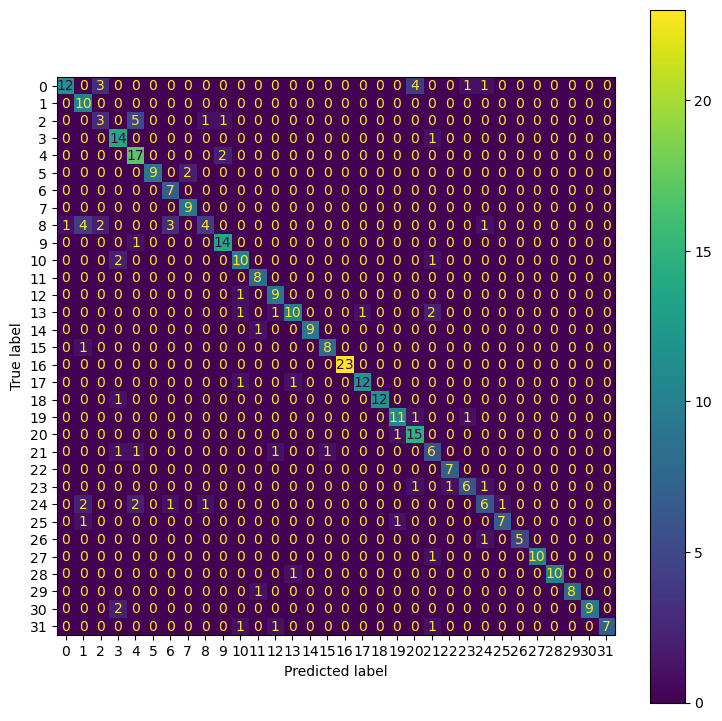

In [27]:
predictions = model.predict(X_test)

prediction_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

print("accuracy:", accuracy_score(y_test_classes, prediction_classes))
print("precision:", precision_score(y_test_classes, prediction_classes, average="macro")) # macro for each label
print("recall:", recall_score(y_test_classes, prediction_classes, average="macro"))
print("f1-score:", f1_score(y_test_classes, prediction_classes, average="macro"))
print("auc score:", roc_auc_score(y_test_classes, predictions, average="macro", multi_class="ovo"))

fig, ax = plt.subplots(figsize=(9, 9))
cm = confusion_matrix(y_test_classes, prediction_classes)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
plt.show()

###### Our model is performing pretty well I would say given the small train size and the big number of classes or leave categories. The architecture is pretty simple as well. Keep in mind we used grayscale images and changed the resolution to be very small. That's why I'm pretty happy with the performance of our model. It definitely didn't generalize too well. This is to be expected given our small train size. The best thing to do here is to increase the train size by many folds!
Now let's experiment with a different architecture

In [32]:
# Define the model
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                           input_shape=(target_height,target_width,1)), # 1 because it's grayscale
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
num_epochs = 300
batch_size = 32
model2_path = "model2.h5"

history = model2.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       tf.keras.callbacks.ModelCheckpoint(model2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )


# Evaluate the model on the train set
train_loss, train_acc = model2.evaluate(X_train, y_train)
print('train accuracy:', train_acc)

Epoch 1/300
46/46 - 5s - loss: 3.0546 - accuracy: 0.1616 - val_loss: 2.0080 - val_accuracy: 0.4545 - 5s/epoch - 112ms/step
Epoch 2/300
46/46 - 4s - loss: 1.3822 - accuracy: 0.6140 - val_loss: 0.9725 - val_accuracy: 0.7143 - 4s/epoch - 81ms/step
Epoch 3/300
46/46 - 4s - loss: 0.7231 - accuracy: 0.7914 - val_loss: 0.8039 - val_accuracy: 0.7403 - 4s/epoch - 80ms/step
Epoch 4/300
46/46 - 7s - loss: 0.5159 - accuracy: 0.8474 - val_loss: 0.6464 - val_accuracy: 0.7792 - 7s/epoch - 152ms/step
Epoch 5/300
46/46 - 8s - loss: 0.3939 - accuracy: 0.8867 - val_loss: 0.5698 - val_accuracy: 0.8442 - 8s/epoch - 170ms/step
Epoch 6/300
46/46 - 7s - loss: 0.3122 - accuracy: 0.8957 - val_loss: 0.5154 - val_accuracy: 0.8312 - 7s/epoch - 153ms/step
Epoch 7/300
46/46 - 9s - loss: 0.2408 - accuracy: 0.9275 - val_loss: 0.6487 - val_accuracy: 0.7792 - 9s/epoch - 192ms/step
Epoch 8/300
46/46 - 11s - loss: 0.1792 - accuracy: 0.9434 - val_loss: 0.4428 - val_accuracy: 0.8571 - 11s/epoch - 240ms/step
Epoch 9/300
46/4

12/12 [==============================] - 0s 24ms/step
accuracy: 0.8743455497382199
precision: 0.8824646045657558
recall: 0.8828942644526527
f1-score: 0.8764183411200578
auc score: 0.992621976806163


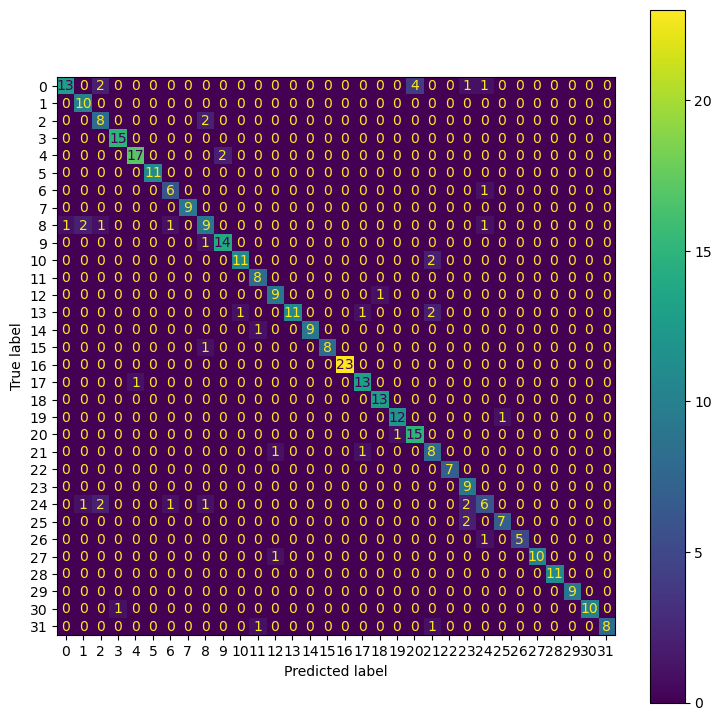

In [33]:
predictions = model2.predict(X_test)

prediction_classes = np.argmax(predictions, axis=1)

print("accuracy:", accuracy_score(y_test_classes, prediction_classes))
print("precision:", precision_score(y_test_classes, prediction_classes, average="macro")) # macro for each label
print("recall:", recall_score(y_test_classes, prediction_classes, average="macro"))
print("f1-score:", f1_score(y_test_classes, prediction_classes, average="macro"))
print("auc score:", roc_auc_score(y_test_classes, predictions, average="macro", multi_class="ovo"))

fig, ax = plt.subplots(figsize=(9, 9))
cm = confusion_matrix(y_test_classes, prediction_classes)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
plt.show()

###### We noticed that as we added one additional convolutional, max pooling, and dense layer followed by a dropout layer, our model was able to generalize significantly better which tells us that we needed to make the model more complex to catch more features and intricaces in the leave images. We increased all the metrics that we're monitoring across the board. I'm sure that as we experiment more, we'd be able to perform even better. I'm thinking that performing some transformations on the images might slightly help as well. I say slightly because these pictures seem to be taken very orderly and systematically and thus, the variation between images won't be so extreme as we see in real life photographs. At the same time, I'm also worried that it might hurt our performance as, again, we have such a small dataset and transforming the training images a lot might give our model a smaller chance to learn the features.

I am still unsure about whether encoding our categories using one-hot-encoding is necessary or helpful. It's worth redoing the assignment without this encoding to see how it will perform.